# **Drug Classification**

Mackenzie Carter, Vannessa Salazar, and Christine Vu

Shiley-Marcos School of Engineering, University of San Diego

ADS 509: Applied Text Mining

Professor Anna Marbut

October 23, 2023

***

## **Data Importing**

### **Import Libraries**

In [1]:
import requests
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn.metrics
import json
import pickle
import string
import os
import re
import nltk
import seaborn as sns
import sqlite3
import random
import gensim
import pyLDAvis
import pyLDAvis.lda_model

from bs4 import BeautifulSoup
from pandas import json_normalize
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from gensim import corpora, models
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
from sklearn.metrics import fowlkes_mallows_score
from sklearn.cluster import KMeans
import pyLDAvis.gensim_models as pyLDAgensimvis
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import euclidean_distances

nltk.download('stopwords')
# stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### **Functions**

In [2]:
def display_topics_lda(lda_model, feature_names, num_terms=10):
    for topic_idx, topic in enumerate(lda_model.get_topics()):
        print(f"Topic {topic_idx + 1}:")
        topic_terms = [feature_names[i] for i in topic.argsort()[:-num_terms - 1:-1]]
        print(", ".join(topic_terms))
        print()

### **Data Ingestion**

In [3]:
# URLs
anx_URL = "https://api.fda.gov/drug/label.json?search=purpose:'anxiety'&limit=10"
pain_URL = "https://api.fda.gov/drug/label.json?search=purpose:'pain'&limit=10"
dementia_URL = "https://api.fda.gov/drug/label.json?search=purpose:'dementia'&limit=100"

In [4]:
def fetch_data_from_api(search_conditions, limit = 100, total_limit = 10000):
    api_endpoint = "https://api.fda.gov/drug/label.json"
    all_data = []

    try:
        while len(all_data) < total_limit:
            params = {
                'search': 'purpose:' + '+'.join(search_conditions),
                'limit': limit,
                'skip': len(all_data)  # Use skip to paginate
            }

            response = requests.get(api_endpoint, params=params)
            if response.status_code == 200:
                data = response.json()
                results = data.get("results", [])
                if not results:
                    break  # No more data available, exit the loop
                all_data.extend(results)
            else:
                print(f"Error: {response.status_code}")
                break
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

    return all_data

# Usage
search_conditions = ['psychiatric', 'pain', 'cholesterol', 'hypertension', 'diabetes', 'infection', 'cancer', 'asthma', 'allergies']
retrieved_data = fetch_data_from_api(search_conditions, limit=1000, total_limit=10000)  # Adjust limit and total_limit as needed
print(len(retrieved_data))  # Print the total number of rows retrieved

10000


In [5]:
df = pd.DataFrame(retrieved_data)

pd.set_option('display.max_columns', None)
df.head()

effective_time                                            purpose  \
0       20171112              [Purpose Pain reliever/fever reducer]   
1       20230328              [Purpose Pain reliever/fever reducer]   
2       20141207  [Reduces occasional pain, pressure and inflamm...   
3       20220407              [Purpose Pain reliever/fever reducer]   
4       20190415  [Purposes Acetaminophen..........................   

                       keep_out_of_reach_of_children  \
0  [Keep out of reach of children. In case of ove...   
1  [Keep out of reach of children. In case of ove...   
2  [Keep this and all medication out of reach of ...   
3  [Keep out of reach of children. Overdose warni...   
4  [Keep this and all drugs out of the reach of c...   

                                          when_using  \
0  [When using this product • take with food or m...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  [When using this product • avoid alcoholic dri...   

                                 questions  \
0  [Questions or comments? 1-888-309-9030]   
1  [Questions or comments? 1-800-426-9391]   
2                                      NaN   
3  [Questions or comments? 1-800-719-9260]   
4                                      NaN   

                         pregnancy_or_breast_feeding  \
0  [If pregnant or breast-feeding, ask a health p...   
1  [If pregnant or breast-feeding, ask a health p...   
2  [If pregnant or breastfeeding, ask a health pr...   
3  [If pregnant or breast-feeding, ask a health p...   
4  [If pregnant or breast-feeding ask a health pr...   

                                storage_and_handling  \
0  [Other information • each capsule contains: so...   
1  [Other information store at 25°C (77°F); excur...   
2  [Tamper resistant for your protection. Use onl...   
3  [Other information • store at 20-25 ° C (68-77...   
4                                                NaN   

                               indications_and_usage  \
0  [Uses • temporarily relieves minor aches and p...   
1  [Uses temporarily relieves minor aches and pai...   
2  [Uses: Homeopathic medicine for temporary reli...   
3  [Uses • temporarily relieves minor aches and p...   
4  [Uses temporarily relieves these common cold/f...   

                                 set_id                                    id  \
0  00051a01-1c2e-4abb-b04c-548401f822c6  bdafad45-6825-4cf2-bb9a-a2ff6ad2e581   
1  0005aafa-08f8-4990-a54d-cc097195708f  32c39abb-4437-45cc-9fb8-4b20baa7c245   
2  000a466f-ae34-4a25-84ec-e97d15a9f3b7  89aa506d-64d5-4c44-8ef1-0f3a2d3ca183   
3  00146b91-008d-4b16-95b0-6077f98821be  8c1bf22a-2d18-4575-8a3d-1f14521d9052   
4  001c9dc0-81cb-454a-a676-a5242e71d386  06e429a5-0429-4899-a0d5-37fa340ccd4e   

                            ask_doctor_or_pharmacist  \
0  [Ask a doctor or pharmacist before use if you ...   
1  [Ask a doctor or pharmacist before use if you ...   
2                                                NaN   
3  [Ask a doctor or pharmacist before use if you ...   
4  [Ask a doctor or pharmacist before use if the ...   

                                   active_ingredient  \
0  [Active ingredient (in each capsule) Naproxen ...   
1  [Active ingredient (in each gelcap) Acetaminop...   
2  [Drug Facts Active Ingredients: Each dose cont...   
3  [Active ingredient (in each caplet) Acetaminop...   
4  [Active Ingredients Acetaminophen 325 mg Dextr...   

                     dosage_and_administration_table  \
0  [<table width="100%"> <col width="24%"/> <col ...   
1                                                NaN   
2                                                NaN   
3  [<table width="100%"><col width="20%"/><col wi...   
4                                                NaN   

                                 inactive_ingredient  \
0  [Inactive ingredients FD&C blue #1, gelatin, g...   
1  

In [6]:
df.shape

(10000, 100)

***

## **Data Preprocessing**

### **Feature Selection**
* Columns Kept: `Purpose`, `Indications and Usage`, `Active Ingredient`, and `Warnings`

### **Preprocessing Functions**
* Remove square brackets: Remove text within square brackets.

* Replace bullet: Replace the bullet character with an empty string.

* Lowercase text: Convert all text to lowercase, so that capitalization does not affect processing.

* Remove punctuation: Eliminate any punctuation marks from the text.

* Tokenize: Split the text into individual words or tokens.

* Remove stopwords: Filter out common stopwords from the text.

In [7]:
columns_to_keep = ['purpose', 'indications_and_usage', 'active_ingredient', 'warnings']

# Create a new DataFrame with only the specified columns
new_df = df.loc[:, columns_to_keep]
new_df.head()

purpose  \
0              [Purpose Pain reliever/fever reducer]   
1              [Purpose Pain reliever/fever reducer]   
2  [Reduces occasional pain, pressure and inflamm...   
3              [Purpose Pain reliever/fever reducer]   
4  [Purposes Acetaminophen..........................   

                               indications_and_usage  \
0  [Uses • temporarily relieves minor aches and p...   
1  [Uses temporarily relieves minor aches and pai...   
2  [Uses: Homeopathic medicine for temporary reli...   
3  [Uses • temporarily relieves minor aches and p...   
4  [Uses temporarily relieves these common cold/f...   

                                   active_ingredient  \
0  [Active ingredient (in each capsule) Naproxen ...   
1  [Active ingredient (in each gelcap) Acetaminop...   
2  [Drug Facts Active Ingredients: Each dose cont...   
3  [Active ingredient (in each caplet) Acetaminop...   
4  [Active Ingredients Acetaminophen 325 mg Dextr...   

                                            warnings  
0  [Warnings Allergy alert: Naproxen sodium may c...  
1  [Warnings Liver warning: This product contains...  
2  [Warnings: If symptoms persist or worsen, cons...  
3  [Warnings Liver warning: This product contains...  
4  [Warnings Liver warning : This product contain...

In [8]:
new_df = new_df.astype(str)

In [9]:
# Apply first round of text cleaning techniques
def clean_num_1(text):
    '''Make all text lowercase, remove text in square brackets, remove punctuation.'''
    if not isinstance(text, str):
        return ''
    text = re.sub(r'\[.*?:\]', '', text)
    text = text.lower()
    text = re.sub(r'/', '/ ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

num1 = lambda x: clean_num_1(x)

In [10]:
sample_text = "[Purpose Pain reliever/fever reducer]"
cleaned_text = clean_num_1(sample_text)
cleaned_text

'purpose pain reliever fever reducer'

In [11]:
cleaned_df = new_df.applymap(clean_num_1)
cleaned_df.head()

C:\Users\Chris\AppData\Local\Temp\ipykernel_63884\3085270577.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned_df = new_df.applymap(clean_num_1)


purpose  \
0                purpose pain reliever fever reducer   
1                purpose pain reliever fever reducer   
2  reduces occasional pain pressure and inflammat...   
3                purpose pain reliever fever reducer   
4  purposes acetaminophenpain reliever fever redu...   

                               indications_and_usage  \
0  uses • temporarily relieves minor aches and pa...   
1  uses temporarily relieves minor aches and pain...   
2  uses homeopathic medicine for temporary relief...   
3  uses • temporarily relieves minor aches and pa...   
4  uses temporarily relieves these common cold fl...   

                                   active_ingredient  \
0  active ingredient in each capsule naproxen sod...   
1  active ingredient in each gelcap acetaminophen...   
2  drug facts active ingredients each dose contai...   
3  active ingredient in each caplet acetaminophen...   
4  active ingredients acetaminophen 325 mg dextro...   

                                            warnings  
0  warnings allergy alert naproxen sodium may cau...  
1  warnings liver warning this product contains a...  
2  warnings if symptoms persist or worsen consult...  
3  warnings liver warning this product contains a...  
4  warnings liver warning  this product contains ...

In [12]:
# Apply second round of text cleaning techniques
def clean_num2(text):
    '''Get rid of some additional punctuation'''
    text = text.replace(u'\u2022', '')  # Replace the bullet character directly
    text = text.replace('[•]', '')  # Replace the pattern as a fallback
    return text

round2 = lambda x: clean_num2(x)

In [13]:
clean_df = cleaned_df.applymap(clean_num2)
clean_df.head()

C:\Users\Chris\AppData\Local\Temp\ipykernel_63884\350708875.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_df = cleaned_df.applymap(clean_num2)


purpose  \
0                purpose pain reliever fever reducer   
1                purpose pain reliever fever reducer   
2  reduces occasional pain pressure and inflammat...   
3                purpose pain reliever fever reducer   
4  purposes acetaminophenpain reliever fever redu...   

                               indications_and_usage  \
0  uses  temporarily relieves minor aches and pai...   
1  uses temporarily relieves minor aches and pain...   
2  uses homeopathic medicine for temporary relief...   
3  uses  temporarily relieves minor aches and pai...   
4  uses temporarily relieves these common cold fl...   

                                   active_ingredient  \
0  active ingredient in each capsule naproxen sod...   
1  active ingredient in each gelcap acetaminophen...   
2  drug facts active ingredients each dose contai...   
3  active ingredient in each caplet acetaminophen...   
4  active ingredients acetaminophen 325 mg dextro...   

                                            warnings  
0  warnings allergy alert naproxen sodium may cau...  
1  warnings liver warning this product contains a...  
2  warnings if symptoms persist or worsen consult...  
3  warnings liver warning this product contains a...  
4  warnings liver warning  this product contains ...

In [14]:
# Create a set of punctuation marks
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Create a set of stopwords
sw = set(stopwords.words('english'))

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Remove stopwords
def remove_stop(tokens):
    """
    Remove stop words from a list of tokens.

    Args:
        tokens (list): List of tokens.

    Returns:
        list: List of tokens with stop words removed.
    """
    filtered_tokens = [word for word in tokens if word.lower() not in sw]
    return filtered_tokens

# Remove punctuation
def remove_punctuation(text, punct_set=tw_punct) :
    return("".join([ch for ch in text if ch not in punct_set]))

# Tokenize
def tokenize(text):
    """
    Split text on whitespace and return tokens.

    Args:
        text (str): Input text.

    Returns:
        list: List of tokens.
    """
    tokens = text.split()

    return tokens

# Applies pipeline to text
def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)

In [15]:
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

In [16]:
clean_df["purpose_tokens"] = clean_df["purpose"].apply(prepare,pipeline=my_pipeline)
clean_df["purpose_num_tokens"] = clean_df["purpose_tokens"].map(len)

clean_df["indications_tokens"] = clean_df["indications_and_usage"].apply(prepare,pipeline=my_pipeline)
clean_df["indications_num_tokens"] = clean_df["indications_tokens"].map(len)

clean_df["active_tokens"] = clean_df["active_ingredient"].apply(prepare,pipeline=my_pipeline)
clean_df["active_num_tokens"] = clean_df["active_tokens"].map(len)

clean_df["warnings_tokens"] = clean_df["warnings"].apply(prepare,pipeline=my_pipeline)
clean_df["warnings_num_tokens"] = clean_df["warnings_tokens"].map(len)

In [17]:
clean_df.head()

purpose  \
0                purpose pain reliever fever reducer   
1                purpose pain reliever fever reducer   
2  reduces occasional pain pressure and inflammat...   
3                purpose pain reliever fever reducer   
4  purposes acetaminophenpain reliever fever redu...   

                               indications_and_usage  \
0  uses  temporarily relieves minor aches and pai...   
1  uses temporarily relieves minor aches and pain...   
2  uses homeopathic medicine for temporary relief...   
3  uses  temporarily relieves minor aches and pai...   
4  uses temporarily relieves these common cold fl...   

                                   active_ingredient  \
0  active ingredient in each capsule naproxen sod...   
1  active ingredient in each gelcap acetaminophen...   
2  drug facts active ingredients each dose contai...   
3  active ingredient in each caplet acetaminophen...   
4  active ingredients acetaminophen 325 mg dextro...   

                                            warnings  \
0  warnings allergy alert naproxen sodium may cau...   
1  warnings liver warning this product contains a...   
2  warnings if symptoms persist or worsen consult...   
3  warnings liver warning this product contains a...   
4  warnings liver warning  this product contains ...   

                                      purpose_tokens  purpose_num_tokens  \
0          [purpose, pain, reliever, fever, reducer]                   5   
1          [purpose, pain, reliever, fever, reducer]                   5   
2  [reduces, occasional, pain, pressure, inflamma...                   6   
3          [purpose, pain, reliever, fever, reducer]                   5   
4  [purposes, acetaminophenpain, reliever, fever,...                  11   

                                  indications_tokens  indications_num_tokens  \
0  [uses, temporarily, relieves, minor, aches, pa...                      22   
1  [uses, temporarily, relieves, minor, aches, pa...                      23   
2  [uses, homeopathic, medicine, temporary, relie...                       8   
3  [uses, temporarily, relieves, minor, aches, pa...                      23   
4  [uses, temporarily, relieves, common, cold, fl...                      22   

                                       active_tokens  active_num_tokens  \
0  [active, ingredient, capsule, naproxen, sodium...                 14   
1  [active, ingredient, gelcap, acetaminophen, 50...                  6   
2  [drug, facts, active, ingredients, dose, conta...                 31   
3  [active, ingredient, caplet, acetaminophen, 50...                  6   
4  [active, ingredients, acetaminophen, 325, mg, ...                 13   

                                     warnings_tokens  warnings_num_tokens  
0  [warnings, allergy, alert, naproxen, sodium, m...                  243  
1  [warnings, liver, warning, product, contains, ...                  142  
2  [warnings, symptoms, persist, worsen, consult,...                    7  
3  [warnings, liver, warning, product, contains, ...                  145  
4  [warnings, liver, warning, product, contains, ...                   61

***

## **Exploratory Data Analysis**

### **Descriptive Statistics**

In [18]:
def descriptive_stats(tokens, num_tokens = 5, verbose = True):

    # Calculate the number of tokens
    num_tokens_total = len(tokens)

    # Calculate the number of unique tokens
    num_unique_tokens = len(set(tokens))

    # Calculate the total number of characters in all tokens
    num_characters = sum(len(token) for token in tokens)

    # Calculate lexical diversity
    if num_tokens_total > 0:
        lexical_diversity = num_unique_tokens / num_tokens_total
    else:
        lexical_diversity = 0.0

    # Count token frequencies
    token_counts = Counter(tokens)

    # Get the top num_tokens most common tokens
    top_tokens = token_counts.most_common(num_tokens)

    if verbose:
        print(f"There are {num_tokens_total} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print("Top {} most common tokens:".format(num_tokens))
        for token, count in top_tokens:
            print(f"{token}: {count}")

    return [num_tokens_total, num_unique_tokens, lexical_diversity, num_characters, top_tokens]

In [19]:
# Define the token categories
token_categories = ['purpose_tokens', 'active_tokens', 'indications_tokens', 'warnings_tokens']

# Initialize a dictionary to store the descriptive statistics
token_desc_stats = {}

# Loop through the token categories and calculate descriptive statistics
for category in token_categories:
    # Extract the tokens for the current category
    all_tokens = [token for tokens_list in clean_df[category] for token in tokens_list]

    # Calculate descriptive statistics for the tokens
    token_desc_stats[category] = descriptive_stats(all_tokens)

    # Print the results for the current category and add a new line
    print(f"{category} statistics:")
    print(token_desc_stats[category])
    print()

There are 150177 tokens in the data.
There are 5745 unique tokens in the data.
There are 1011262 characters in the data.
The lexical diversity is 0.038 in the data.
Top 5 most common tokens:
pain: 10545
reliever: 7798
purpose: 7289
fever: 5938
reducer: 5443
purpose_tokens statistics:
[150177, 5745, 0.03825485926606604, 1011262, [('pain', 10545), ('reliever', 7798), ('purpose', 7289), ('fever', 5938), ('reducer', 5443)]]

There are 222463 tokens in the data.
There are 5734 unique tokens in the data.
There are 1381707 characters in the data.
The lexical diversity is 0.026 in the data.
Top 5 most common tokens:
mg: 15052
active: 11251
ingredients: 5974
ingredient: 5568
acetaminophen: 4860
active_tokens statistics:
[222463, 5734, 0.025775072708720103, 1381707, [('mg', 15052), ('active', 11251), ('ingredients', 5974), ('ingredient', 5568), ('acetaminophen', 4860)]]

There are 270827 tokens in the data.
There are 5354 unique tokens in the data.
There are 1746809 characters in the data.
The l

### **Top Token Frequencies**

In [20]:
# Define the token categories
token_categories = ['purpose_tokens', 'active_tokens', 'indications_tokens', 'warnings_tokens']

# Initialize a dictionary to store the descriptive statistics
token_desc_stats = {}

# Calculate concentration and filter tokens
def calculate_lyrics_concentration(tokens):
    token_counts = Counter(tokens)
    concentration = [count / len(tokens) for count in token_counts.values()]
    return token_counts, concentration

# Find the top 10 unique tokens and their concentrations for each category
for category in token_categories:
    # Calculate token counts and concentration for each category
    token_counts, concentration = calculate_lyrics_concentration([token for tokens_list in clean_df[category] for token in tokens_list])

    # Create a dataFrame for token statistics
    token_stats_df = pd.DataFrame({
        'Token': token_counts.keys(),
        f'{category} Count': token_counts.values(),
        f'{category} Concentration': concentration
    })

    # Sort the dataFrame by concentration in descending order
    token_stats_df = token_stats_df.sort_values(by = f'{category} Concentration', ascending = False)

    # Display the top 10 tokens and their concentrations
    print(f"Top 10 Unique Tokens in '{category}':")
    print(token_stats_df.head(10))
    print()

Top 10 Unique Tokens in 'purpose_tokens':
           Token  purpose_tokens Count  purpose_tokens Concentration
1           pain                 10545                      0.070217
2       reliever                  7798                      0.051925
0        purpose                  7289                      0.048536
3          fever                  5938                      0.039540
4        reducer                  5443                      0.036244
44         cough                  2543                      0.016933
43         nasal                  2465                      0.016414
14   suppressant                  2319                      0.015442
17  decongestant                  2312                      0.015395
95            mg                  2239                      0.014909

Top 10 Unique Tokens in 'active_tokens':
             Token  active_tokens Count  active_tokens Concentration
6               mg                15052                     0.067661
0           active 

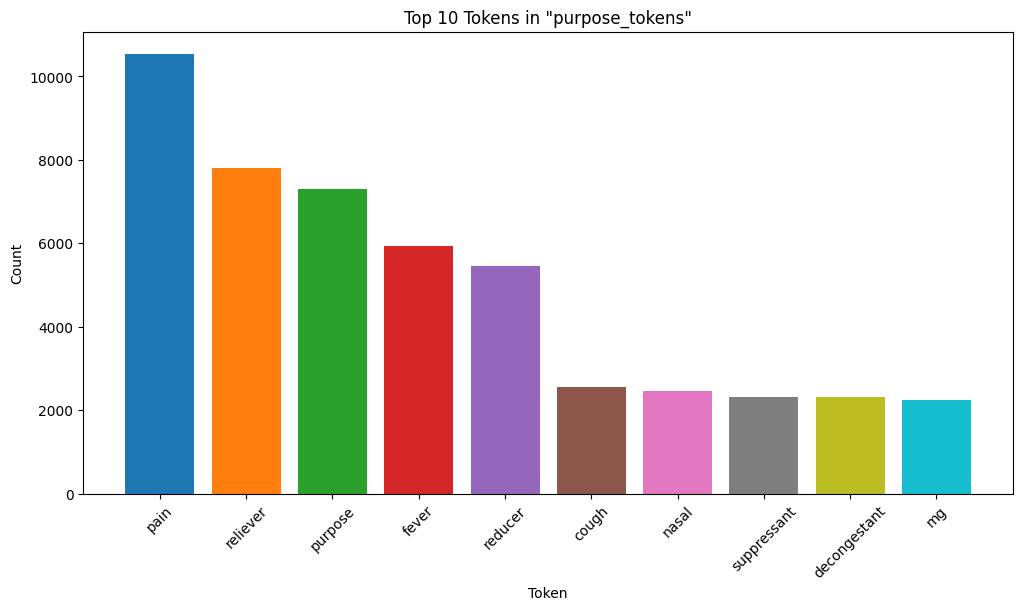

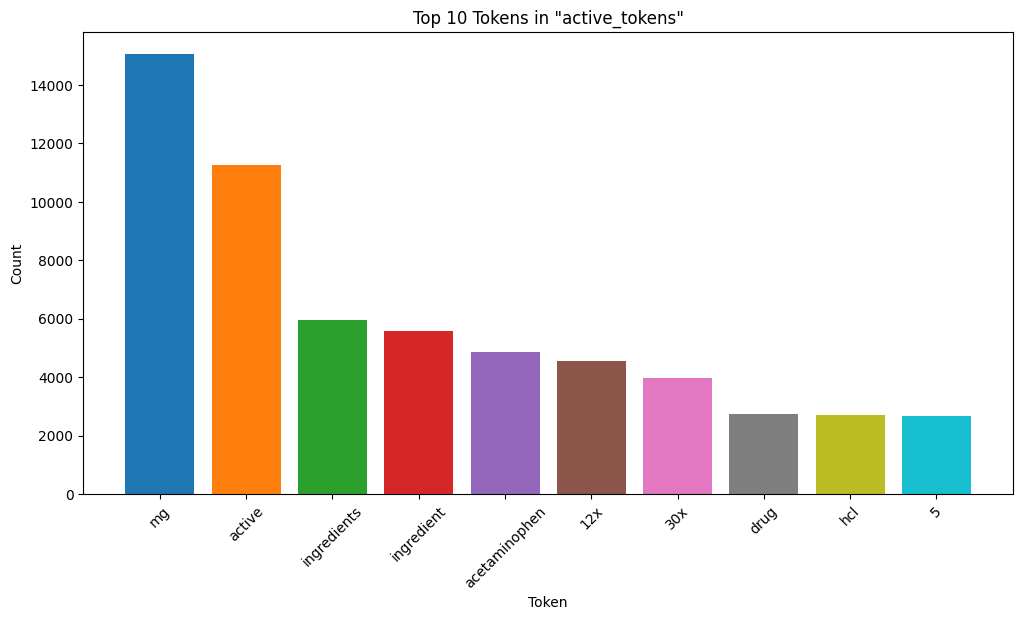

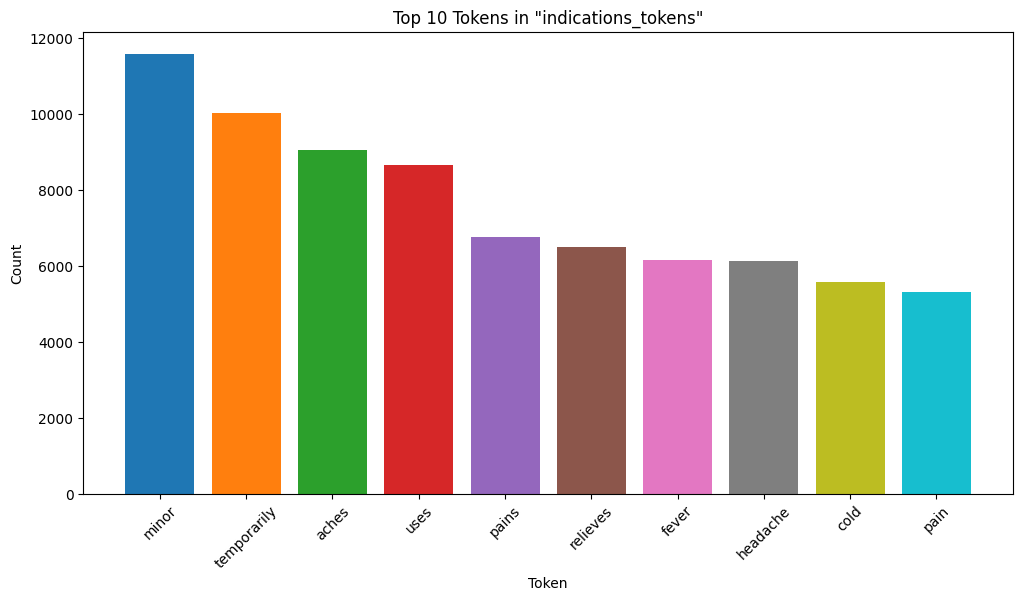

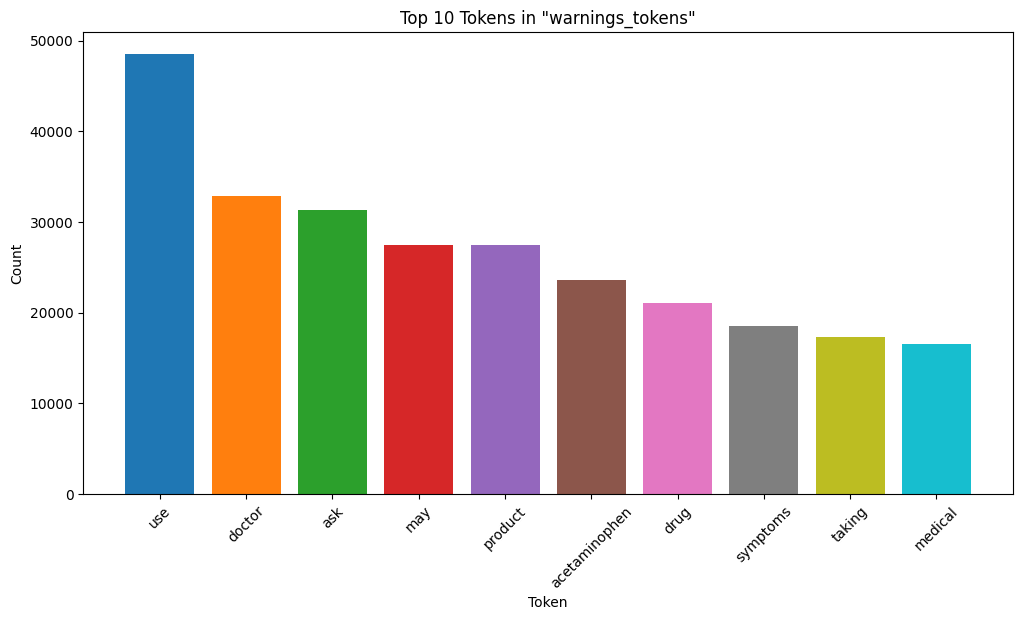

In [21]:
# Create bar plots for each column
for column in token_categories:
    # Count the occurrences of each token in the column
    token_counts = clean_df[column].apply(lambda x: Counter(x))

    # Sum the token counts across all rows
    total_counts = token_counts.sum()

    # Get the top N tokens to display (adjust the number as needed)
    top_tokens = total_counts.most_common(10)

    # Create a bar plot for the token frequencies
    plt.figure(figsize = (12, 6))
    for i, (token, count) in enumerate(top_tokens):
        plt.bar(token, count, label = token)

    plt.title(f'Top 10 Tokens in "{column}"')
    plt.xlabel('Token')
    plt.ylabel('Count')
    plt.xticks(rotation = 45)
    plt.show()

### **Distribution: Amount of Tokens**

* Histogram

* Box Plot

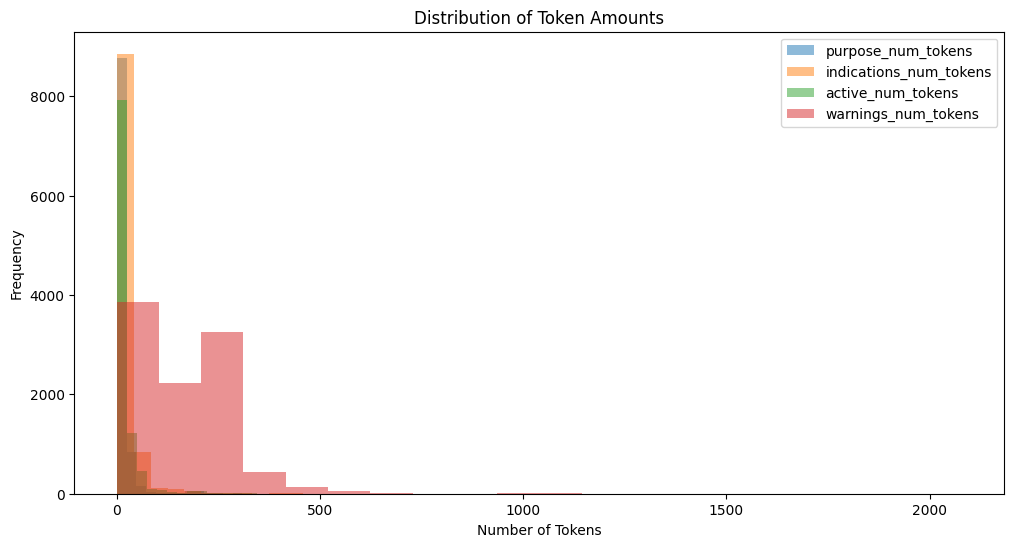

In [22]:
# List of column names
num_token_columns = ['purpose_num_tokens', 'indications_num_tokens', 'active_num_tokens', 'warnings_num_tokens']

# Create histograms for the token amounts in each column
plt.figure(figsize = (12, 6))
for column in num_token_columns:
    plt.hist(clean_df[column], bins = 20, alpha = 0.5, label=column)

plt.title('Distribution of Token Amounts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

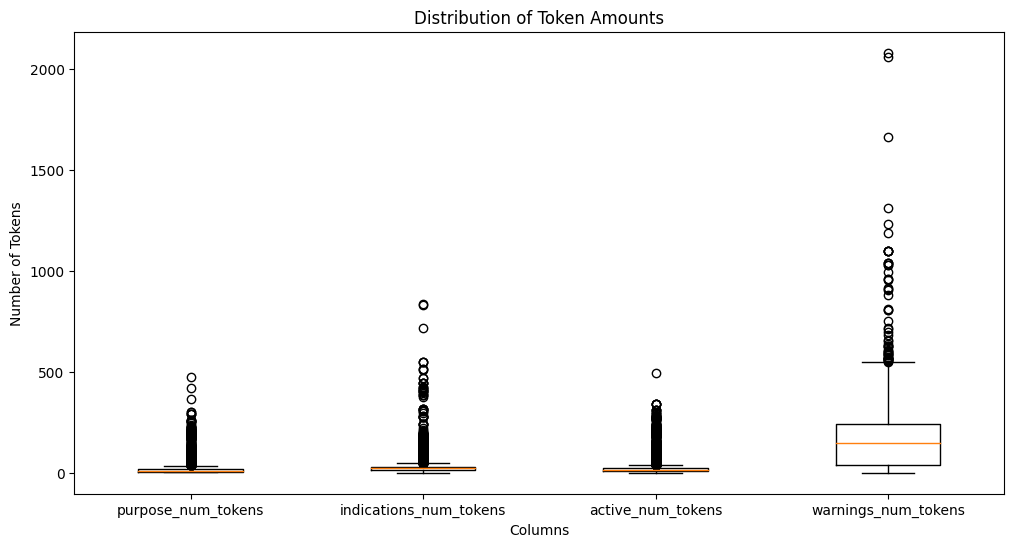

In [23]:
# Create box plots for the token amounts in each column
plt.figure(figsize = (12, 6))
plt.boxplot([clean_df[column] for column in num_token_columns], labels = num_token_columns)
plt.title('Distribution of Token Amounts')
plt.xlabel('Columns')
plt.ylabel('Number of Tokens')
plt.show()

### **Word Cloud**

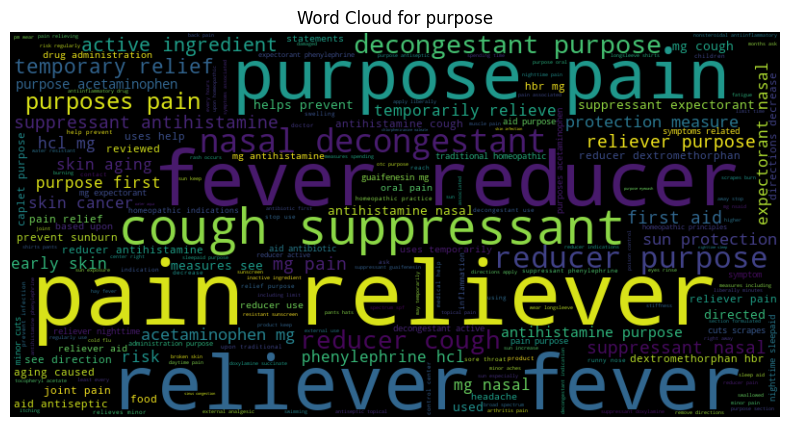

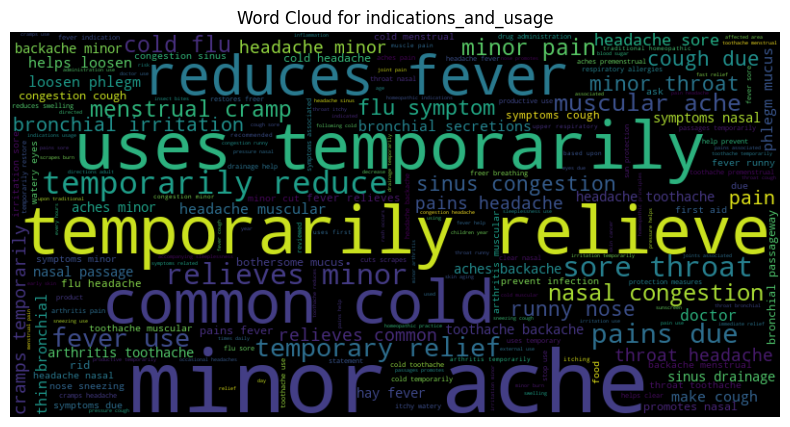

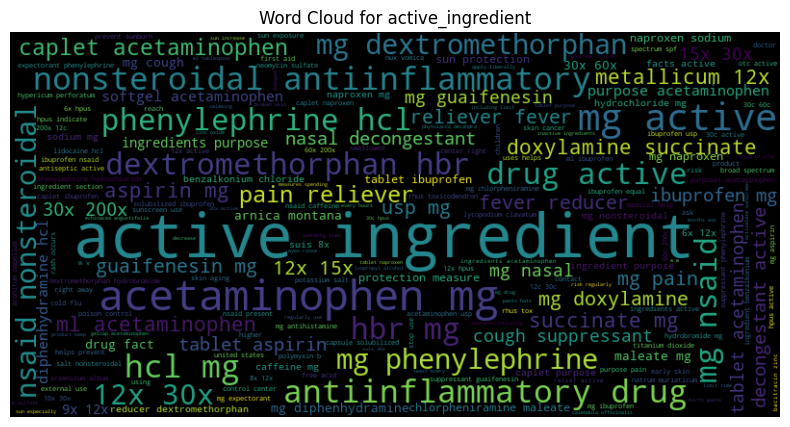

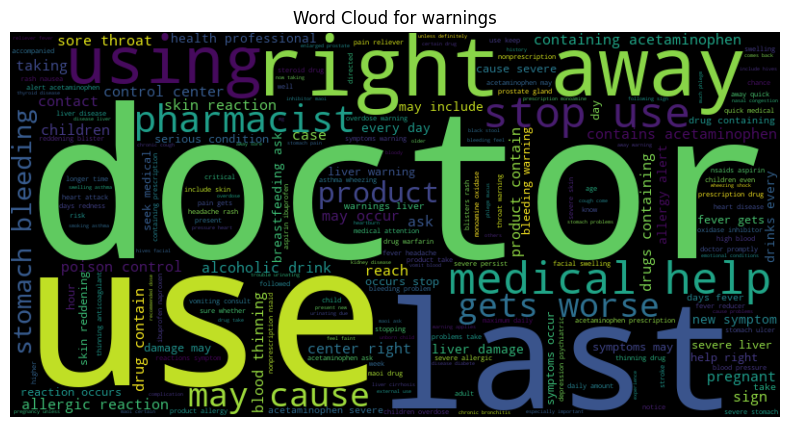

In [24]:
# Define the text columns
text_columns = ['purpose', 'indications_and_usage', 'active_ingredient', 'warnings']

# Create a word cloud for each text column
for column in text_columns:
    # Combine the text data from the column into a single string
    text_data = ' '.join(clean_df[column].astype(str))

    # Create and generate a WordCloud object
    wordcloud = WordCloud(width = 800, height = 400).generate(text_data)

    # Display the word cloud
    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {column}")
    plt.show()

***

## **Topic Modeling**

### **Latent Dirichlet Allocation (LDA)**

In [25]:
# First initial exploration into patterns between all columns
stopwords = set(nltk.corpus.stopwords.words('english'))
clean_df_save = clean_df
clean_df['combined_text'] = clean_df['purpose_tokens'].apply(lambda tokens: ' '.join(tokens)) + ' ' + \
                           clean_df['indications_tokens'].apply(lambda tokens: ' '.join(tokens)) + ' ' + \
                           clean_df['active_tokens'].apply(lambda tokens: ' '.join(tokens)) + ' ' + \
                           clean_df['warnings_tokens'].apply(lambda tokens: ' '.join(tokens))

In [26]:
clean_df.head(5)

purpose  \
0                purpose pain reliever fever reducer   
1                purpose pain reliever fever reducer   
2  reduces occasional pain pressure and inflammat...   
3                purpose pain reliever fever reducer   
4  purposes acetaminophenpain reliever fever redu...   

                               indications_and_usage  \
0  uses  temporarily relieves minor aches and pai...   
1  uses temporarily relieves minor aches and pain...   
2  uses homeopathic medicine for temporary relief...   
3  uses  temporarily relieves minor aches and pai...   
4  uses temporarily relieves these common cold fl...   

                                   active_ingredient  \
0  active ingredient in each capsule naproxen sod...   
1  active ingredient in each gelcap acetaminophen...   
2  drug facts active ingredients each dose contai...   
3  active ingredient in each caplet acetaminophen...   
4  active ingredients acetaminophen 325 mg dextro...   

                                            warnings  \
0  warnings allergy alert naproxen sodium may cau...   
1  warnings liver warning this product contains a...   
2  warnings if symptoms persist or worsen consult...   
3  warnings liver warning this product contains a...   
4  warnings liver warning  this product contains ...   

                                      purpose_tokens  purpose_num_tokens  \
0          [purpose, pain, reliever, fever, reducer]                   5   
1          [purpose, pain, reliever, fever, reducer]                   5   
2  [reduces, occasional, pain, pressure, inflamma...                   6   
3          [purpose, pain, reliever, fever, reducer]                   5   
4  [purposes, acetaminophenpain, reliever, fever,...                  11   

                                  indications_tokens  indications_num_tokens  \
0  [uses, temporarily, relieves, minor, aches, pa...                      22   
1  [uses, temporarily, relieves, minor, aches, pa...                      23   
2  [uses, homeopathic, medicine, temporary, relie...                       8   
3  [uses, temporarily, relieves, minor, aches, pa...                      23   
4  [uses, temporarily, relieves, common, cold, fl...                      22   

                                       active_tokens  active_num_tokens  \
0  [active, ingredient, capsule, naproxen, sodium...                 14   
1  [active, ingredient, gelcap, acetaminophen, 50...                  6   
2  [drug, facts, active, ingredients, dose, conta...                 31   
3  [active, ingredient, caplet, acetaminophen, 50...                  6   
4  [active, ingredients, acetaminophen, 325, mg, ...                 13   

                                     warnings_tokens  warnings_num_tokens  \
0  [warnings, allergy, alert, naproxen, sodium, m...                  243   
1  [warnings, liver, warning, product, contains, ...                  142   
2  [warnings, symptoms, persist, worsen, consult,...                    7   
3  [warnings, liver, warning, product, contains, ...                  145   
4  [warnings, liver, warning, product, contains, ...                   61   

                                       combined_text  
0  purpose pain reliever fever reducer uses tempo...  
1  purpose pain reliever fever reducer uses tempo...  
2  reduces occasional pain pressure inflammation ...  
3  purpose pain reliever fever reducer uses tempo...  
4  purposes acetaminophenpain reliever fever redu...

In [27]:
stopwords = set(nltk.corpus.stopwords.words('english'))

# Vectorizer
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(clean_df["combined_text"])
#count_text_vectors.shape

# Gensim corpus
corpus = gensim.matutils.Sparse2Corpus(count_text_vectors.T)
gensim_dict = dict((v, k) for k, v in count_text_vectorizer.vocabulary_.items())
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, id2word=gensim_dict)

# LDA
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=123)

# Display Topics
display_topics_lda(lda_model, count_text_vectorizer.get_feature_names_out())

Topic 1:
acetaminophen, fever, mg, drug, liver, cough, occur, taking, severe, contains

Topic 2:
stomach, bleeding, aspirin, fever, drug, problems, allergic, heart, take, directed

Topic 3:
sun, skin, sunscreen, water, protection, extract, measures, risk, 15, cancer

Topic 4:
12x, 30x, 15x, 6x, hpus, relief, indications, ingredients, homeopathic, temporary

Topic 5:
purpose, aid, external, first, ingredient, relief, contact, burns, eyes, get



In [28]:
# Visualize LDA results
lda_display = gensimvis.prepare(lda_model, corpus, dictionary = dictionary)
pyLDAvis.display(lda_display)

***

## **Classification Modeling**

### **Fuzzy C-Means**

In [29]:
# Extract topic probabilities from the LDA model
document_topic_probs = [lda_model.get_document_topics(doc) for doc in corpus]

In [30]:
# Due to irregular lengths of the topic probabilities, we need to pad each prob of each document
# This will make sure they are uniform and will allow k-means to properly work

# Find the maximum number of topics in any document
max_num_topics = max(len(doc_probs) for doc_probs in document_topic_probs)

# Create empty array to store padded topic probabilities
padded_document_topic_probs = []

# Pad the topic probabilities for each document
for doc_probs in document_topic_probs:
    # Create a dictionary to store topic probabilities for this document
    padded_probs = {}
    for topic_idx, prob in doc_probs:
        padded_probs[topic_idx] = prob
    # Pad missing topics with probability 0
    for topic_idx in range(max_num_topics):
        if topic_idx not in padded_probs:
            padded_probs[topic_idx] = 0
    # Append the padded topic probabilities to the array
    padded_document_topic_probs.append([padded_probs[i] for i in range(max_num_topics)])

# Convert the list of lists into a 2D numpy array
document_topic_probs_array = np.array(padded_document_topic_probs)

In [32]:
# Find the maximum number of topics in any document
max_num_topics = max(len(doc_probs) for doc_probs in document_topic_probs)

# Create an empty array to store padded topic probabilities
padded_document_topic_probs = []

# Pad the topic probabilities for each document
for doc_probs in document_topic_probs:
    # Create a list to store the padded topic probabilities for this document
    padded_probs = [0.0] * max_num_topics
    for topic_idx, prob in doc_probs:
        padded_probs[topic_idx] = prob
    # Append the padded topic probabilities to the array
    padded_document_topic_probs.append(padded_probs)

# Convert the list of lists into a numpy array
document_topic_probs_array = np.array(padded_document_topic_probs)

In [33]:
# Perform fuzzy c-means similar to k-means, but generalizes more

# Number of clusters (adjust this based on your data)
num_clusters = 5

# Fuzzy C-means clustering
def fuzzy_cmeans(X, num_clusters, m=2, error=0.005, max_iter=1000):
    n_samples, n_features = X.shape
    # Initialize cluster centers
    centers = np.random.rand(num_clusters, n_features)
    centers /= centers.sum(axis=1)[:, np.newaxis]

    prev_membership = np.zeros((n_samples, num_clusters))

    for _ in range(max_iter):
        # Calculate distances between samples and centers
        distances = euclidean_distances(X, centers)

        # Calculate membership
        membership = 1 / (distances ** (2 / (m - 1)))
        membership /= membership.sum(axis=1)[:, np.newaxis]

        # Update cluster centers
        centers = membership.T @ X
        centers /= membership.sum(axis=0)[:, np.newaxis]

        # Check for convergence
        if np.linalg.norm(membership - prev_membership) < error:
            break

        prev_membership = membership

    return membership

# Perform Fuzzy C-means clustering
membership = fuzzy_cmeans(document_topic_probs_array, num_clusters)

# Assign pseudo labels based on cluster memberships
pseudo_labels = np.argmax(membership, axis=1)

# Add pseudo labels to your DataFrame
clean_df['pseudo_label'] = pseudo_labels

# Print the counts of documents in each pseudo cluster
print(clean_df['pseudo_label'].value_counts())

pseudo_label
0    4238
3    2362
4    2046
2     914
1     440
Name: count, dtype: int64


In [34]:
# Visualize Fuzzy C-Means Clusters

# Calculate cluster statistics
cluster_statistics = []

for cluster_label in range(num_clusters):
    cluster_data = clean_df[clean_df['pseudo_label'] == cluster_label]
    avg_document_length = cluster_data['combined_text'].apply(lambda x: len(x.split())).mean()
    most_common_words = " ".join(cluster_data['combined_text']).split()

    word_counts = Counter(most_common_words)
    top_words = word_counts.most_common(10)  # Get top N words

    cluster_stats = {
        'Cluster Label': cluster_label,
        'Number of Documents': len(cluster_data),
        'Average Document Length': avg_document_length,
        'Top Words': [word for word, count in top_words]
    }

    cluster_statistics.append(cluster_stats)

# Display cluster statistics
cluster_stats_df = pd.DataFrame(cluster_statistics)
print(cluster_stats_df)

   Cluster Label  Number of Documents  Average Document Length  \
0              0                 4238               243.861727   
1              1                  440               272.609091   
2              2                  914               203.202407   
3              3                 2362               280.078323   
4              4                 2046               102.168622   

                                           Top Words  
0  [acetaminophen, use, ask, doctor, product, mg,...  
1  [sun, use, skin, sunscreen, protection, water,...  
2  [use, doctor, pain, ask, active, purpose, help...  
3  [stomach, use, pain, may, bleeding, doctor, as...  
4  [12x, use, pain, 30x, symptoms, 15x, 6x, relie...  


In [35]:
# MC - grabbing table for top words, can delete before sub
top_words_dict = {'Cluster Label': []}
num_top_words = 5  # Specify the number of top words to retrieve

# Calculate top words for each cluster
for cluster_label in range(num_clusters):
    cluster_data = clean_df[clean_df['pseudo_label'] == cluster_label]
    most_common_words = " ".join(cluster_data['combined_text']).split()

    word_counts = Counter(most_common_words)
    top_words = word_counts.most_common(num_top_words)  # Get top N words
    top_words_list = [word for word, count in top_words]

    cluster_label_str = f'Cluster {cluster_label}'
    top_words_dict['Cluster Label'].append(cluster_label_str)
    top_words_dict[cluster_label_str] = top_words_list + [None] * (num_top_words - len(top_words_list))

# Display top words for each cluster
top_words_df = pd.DataFrame(top_words_dict)
top_words_df

Cluster Label      Cluster 0   Cluster 1 Cluster 2 Cluster 3 Cluster 4
0     Cluster 0  acetaminophen         sun       use   stomach       12x
1     Cluster 1            use         use    doctor       use       use
2     Cluster 2            ask        skin      pain      pain      pain
3     Cluster 3         doctor   sunscreen       ask       may       30x
4     Cluster 4        product  protection    active  bleeding  symptoms

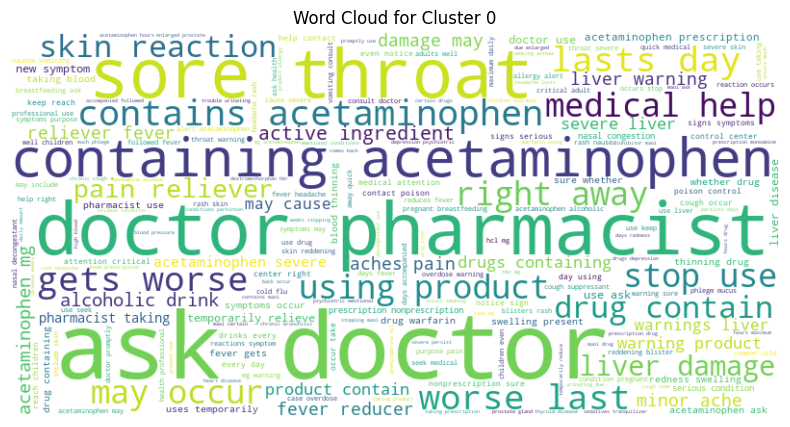

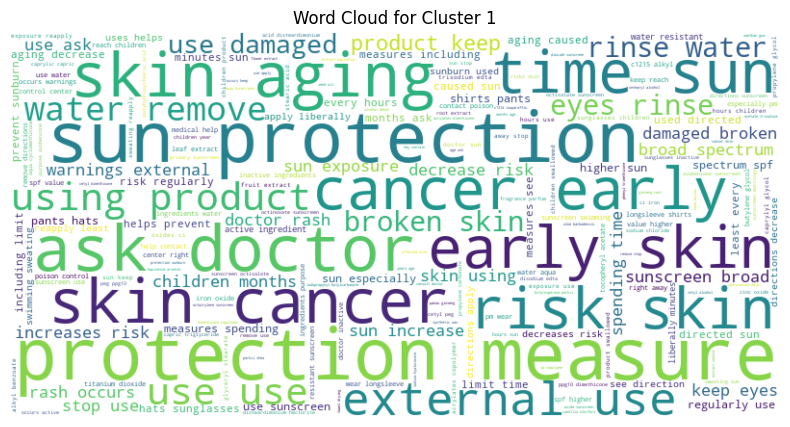

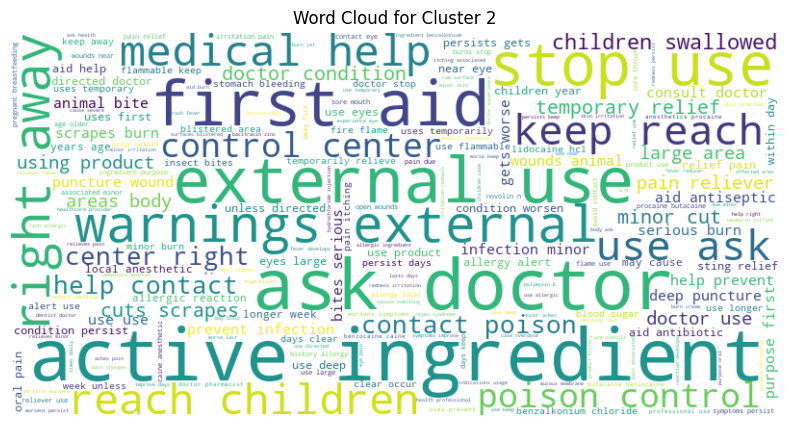

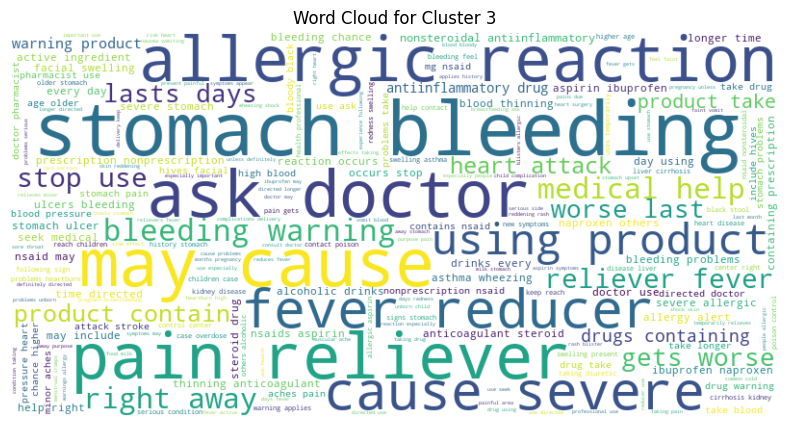

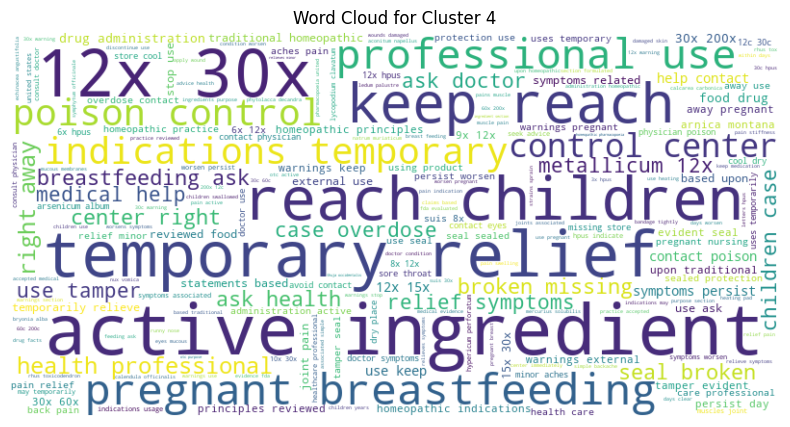

In [36]:
# Visualize with word cloud

# Function to generate and display word cloud for a specific cluster
def generate_word_cloud(cluster_data, cluster_label):
    words = " ".join(cluster_data['combined_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_label}')
    plt.show()

# Generate word clouds for each cluster
for cluster_label in range(num_clusters):
    cluster_data = clean_df[clean_df['pseudo_label'] == cluster_label]
    generate_word_cloud(cluster_data, cluster_label)

### **K-Means**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

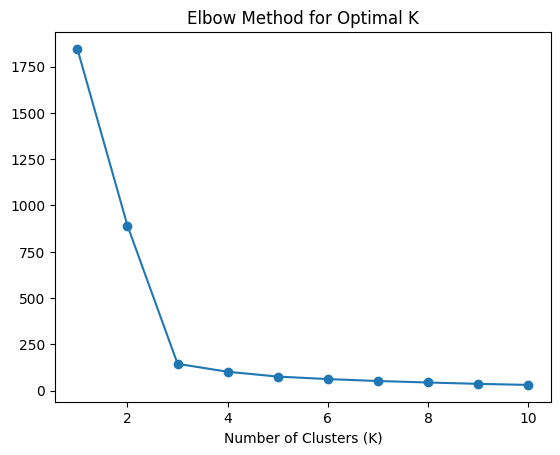

In [60]:
# Create a TF-IDF vectorizer to convert text data to numerical features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(clean_df['combined_text'])

# Reduce dimensionality using Truncated SVD
n_components = 2
lsa = TruncatedSVD(n_components=n_components)
X_lsa = lsa.fit_transform(X_tfidf)

# Determine the number of clusters (K) using the "elbow method"
elbow = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_lsa)
    elbow.append(kmeans.inertia_)

# Plot the "elbow" to find the optimal number of clusters
plt.figure()
plt.plot(range(1, 11), elbow, marker = 'o')
plt.xlabel('Number of Clusters (K)')
plt.title('Elbow Method for Optimal K')
plt.show()

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


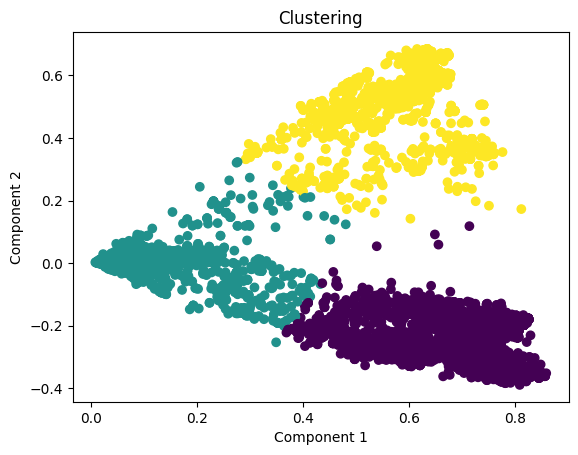

In [61]:
# Based on the optimal K from the elbow method, perform clustering
optimal_k = 3
kmeans = KMeans(n_clusters = optimal_k, random_state = 42)
cluster_labels = kmeans.fit_predict(X_lsa)

# Add cluster labels to the dataFrame
clean_df['cluster_label'] = cluster_labels

# Visualize the clusters
plt.scatter(X_lsa[:, 0], X_lsa[:, 1], c = cluster_labels, cmap = 'viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Clustering')
plt.show()

In [65]:
# Visualize K-Means Clusters

# Calculate cluster statistics
cluster_statistics = []

for cluster_label in range(num_clusters):
    cluster_data = clean_df[clean_df['cluster_label'] == cluster_label]
    num_documents = len(cluster_data)
    
    # Calculate the average document length
    avg_document_length = cluster_data['combined_text'].apply(lambda x: len(x.split())).mean()
    
    cluster_stats = {
        'Cluster Label': cluster_label,
        'Number of Documents': num_documents,
        'Average Document Length': avg_document_length,
    }
    
    cluster_statistics.append(cluster_stats)

# Display cluster statistics
cluster_stats_df = pd.DataFrame(cluster_statistics)
print(cluster_stats_df)

   Cluster Label  Number of Documents  Average Document Length
0              0                 4069               249.447776
1              1                 3588               145.363434
2              2                 2343               287.313700


In [70]:
# Create an empty DataFrame
top_words_df = pd.DataFrame(columns = ["Cluster Label", "Top Words"])

# Calculate top words for each cluster
for cluster_label in range(num_clusters):
    cluster_data = clean_df[clean_df['cluster_label'] == cluster_label]
    most_common_words = " ".join(cluster_data['combined_text']).split()

    word_counts = Counter(most_common_words)
    top_words = word_counts.most_common(5)
    top_words_list = [word for word, count in top_words]
    
    cluster_label_str = f'Cluster {cluster_label}'
    top_words_df = pd.concat([top_words_df, pd.DataFrame({"Cluster Label": [cluster_label_str], "Top Words": [top_words_list]})], ignore_index=True)

# Display top words for each cluster
top_words_df

Cluster Label                                   Top Words
0     Cluster 0  [acetaminophen, use, ask, doctor, product]
1     Cluster 1              [use, pain, skin, doctor, ask]
2     Cluster 2         [use, stomach, pain, may, bleeding]

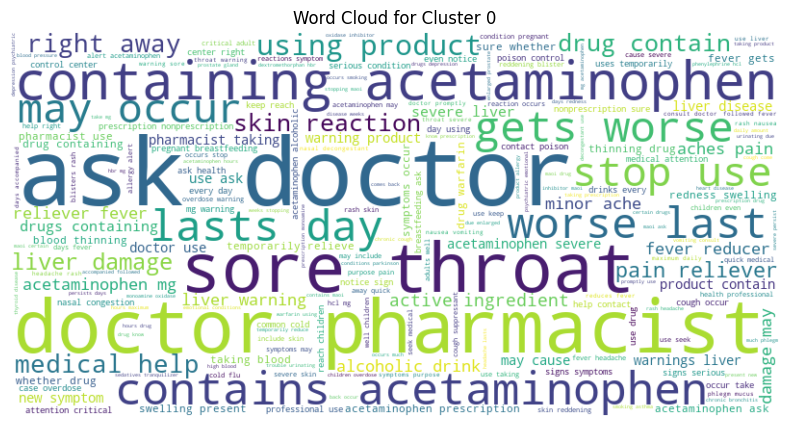

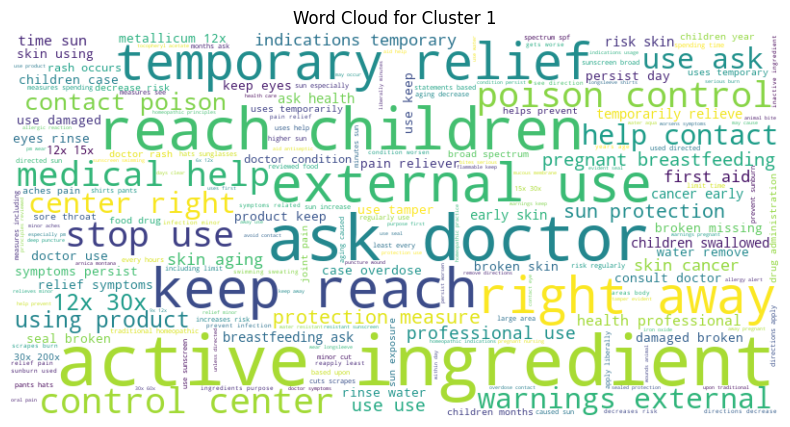

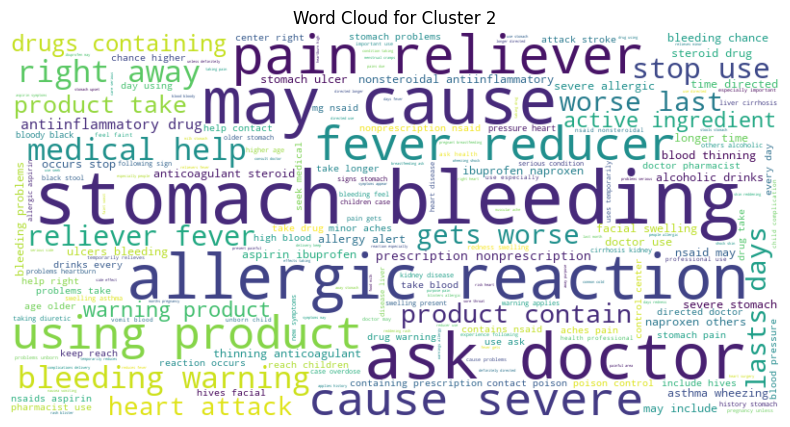

In [66]:
# Function to generate and display word cloud for a specific cluster
def generate_word_cloud(cluster_data, cluster_label):
    words = " ".join(cluster_data['combined_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_label}')
    plt.show()

# Generate word clouds for each cluster
for cluster_label in range(num_clusters):
    cluster_data = clean_df[clean_df['cluster_label'] == cluster_label]
    generate_word_cloud(cluster_data, cluster_label)